Project 3: Traveling Salesman Problem using Ant Colony Optimization (ACO)
---
Authors: Dawson Merkle and Thomas Levitt
---
Date: 6/22/23
---
Class: CAP 4630

**DEPENDENCIES**

*   random
*   numpy
*   matplotlib.pyplot
*   math
*   copy










In [ ]:
# Authors: Dawson Merkle : Thomas Levitt
# Date: 6/22/23
# Assignment 3
# CAP 4630


# Steps to the Algorithm
# 1. Set up Pheromones
# 2. Set up the Population of Ants
# 3. Choose the Next Visit for each Ant
# 4. Are there more Destinations?
    # If yes, go back to 3
    # If no, move to 5
# 5. Update the Pheromone Trails
# 6. Update the Best Solution
# 7. Reached Stopping Condition?
    # If no, go back to 2
    # If yes, move to 8
# 8. Return the Best Solution


import random
import numpy as np
import matplotlib.pyplot as plt
import math
import copy


class City():
    '''city class'''

    def __init__(self, name, x, y):
        '''constructor'''
        self.name = name
        self.x = x
        self.y = y

    def get_distance(self, other):
        '''gets distance from one city from another'''
        xDis = abs(self.x - other.x)
        yDis = abs(self.y - other.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance

    def get_coords(self):
        '''returns tuple of x and y'''
        return self.x, self.y

    def get_name(self):
        '''returns string representation as function.
            Usable as object call'''

        return '({name})'.format(name = self.name)

    def __repr__(self):
        '''returns string representation of city'''

        return '({name}: x:{x}, y:{y})'.format(name = self.name,
                                         x = self.x, y = self.y)


class Ant():
    '''ant class'''

    def __init__(self, name):
        '''constructor'''

        self.name = name
        self.tourList = []
        self.distance = 0

    def set_start(self, startPoint):
        '''#defines starting point in list'''
        self.tourList.append(startPoint)

    def visit(self, cityObject):
        '''Ant has visited this city'''
        self.tourList.append(cityObject)

    def get_tour(self, reset=False):

        if reset:
            self.tourList = []

        return self.tourList

    def set_distance(self, antDistance):
        '''sets distance of ant'''

        self.distance = antDistance

    def get_distance(self):
        '''gets distance of ant'''

        return self.distance

    def __repr__(self):
        '''returns string representation of ant'''

        return '({name}: list: {tourList})'.format(name = self.name,
                                                   tourList = self.tourList)


def plot_generations_and_route(bestIterationDistance, NUM_ITERATIONS,
                               bestGlobalRoute, bestGlobalDistance):
    '''plots the best routes per iteration and the best route length with
        a diagram showing where the cities are'''

    plt.figure(figsize=(9.5,9.5))

    # Plotting the iteration plot
    xaxis = list(range(0, NUM_ITERATIONS))

    plt.subplot(2, 1, 1)
    plt.plot(xaxis, bestIterationDistance)
    plt.title('Best Routes Each Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Route Distance')


    # Plotting the Best Tour plot
    xLis = []
    yLis = []
    for city in bestGlobalRoute:

        xPos, yPos = city.get_coords()

        xLis.append(xPos)
        yLis.append(yPos)

    xLast, yLast = bestGlobalRoute[0].get_coords()
    xLis.append(xLast)
    yLis.append(yLast)

    plt.subplot(2, 1, 2)
    plt.axis([0, 200, 0, 200])

    plt.plot(xLis, yLis, c='black', mfc='red', marker='o',
             markersize='7', label='Cities')
    plt.plot(xLis[0], yLis[0], c='black', mfc='green', marker='s',
             markersize='9', label='Start')
    plt.plot(xLis[1], yLis[1], c='black', mfc='purple', marker='D',
             markersize='9', label='Next')
    plt.title('Best Route with length of: ' + str(round(bestGlobalDistance, 3)))
    plt.legend()

    # Plot both subplots
    plt.tight_layout(pad=4.0)
    plt.show()


def proportional_roulette_selection(probList):
    '''selecting the next city using proportional roulette selection'''

    # creating the slices of the roulette wheel
    slices = []
    for slice in range(len(probList)):
        sliceCounter = 0
        if slice == 0:
            slices.append(probList[0])
        else:
            slices.append(slices[sliceCounter-1] + probList[slice])

    # creating a random number to choose slice
    randomNumber = random.uniform(0,1)

    # return the slice that was chosen
    for index, slice in enumerate(slices):
        if randomNumber < slice:
            return index


def create_probabilities(ant, cityList, strCityList, disMatrix, pheratrix,
                         ALPHA, BETA):
    '''create probabilities for cities to be used in roulette for an ant'''

    denominator = 0
    currentCity = cityList.index(ant.get_tour()[-1])
    unVisitedList = []
    probList = []

    # gets string representation of city
    for city in cityList:
        if city not in ant.get_tour():
            i = strCityList.index(city.__repr__())
            unVisitedList.append(i)

    # creates denominator for formula
    for city in unVisitedList:
        if currentCity == city:
            continue

        denominator += ((pheratrix[currentCity][city]**ALPHA) *
                        ((1/disMatrix[currentCity][city])**BETA))

    # creates numerator and preforms probability calculation for each city
    for city in unVisitedList:
        if currentCity == city:
            continue

        numerator = ((pheratrix[currentCity][city]**ALPHA) *
                        ((1/disMatrix[currentCity][city])**BETA))

        cityProb = numerator / denominator

        probList.append(cityProb)

    return probList, unVisitedList


def do_tour(ant, cityList, strCityList, disMatrix, pheratrix, ALPHA, BETA,
            bestGlobalDistance, bestGlobalRoute, tempPheramones, RANDOM_ATTRACTION_FACTOR):
    '''does tour for all ants'''

    for _ in range(len(cityList) - 1):
        # creating the probabilities of choosing unvisited cities
        probList, unVisitedList = create_probabilities(ant, cityList, strCityList,
                                                    disMatrix, pheratrix,
                                                    ALPHA, BETA)

        # choosing the next city through roulette selection
        indexofNextCity = proportional_roulette_selection(probList)

        # choosing the next city randomly if triggered
        tempRandomNum = random.uniform(0,1)
        if tempRandomNum <= RANDOM_ATTRACTION_FACTOR:
            tempindex = random.choice(unVisitedList)
        else:
            tempindex = unVisitedList[indexofNextCity]

        # visit the city that has been chosen
        ant.visit(cityList[tempindex])

    # finding the total distance for the ants route
    totalDis = 0
    for index in range(len(cityList)):
        if index == (len(cityList)-1):
            totalDis += ant.get_tour()[index].get_distance(ant.get_tour()[0])
        else:
            totalDis += ant.get_tour()[index].get_distance(
                ant.get_tour()[index+1])

    # setting the total distance to the ant
    ant.set_distance(totalDis)

    # updating temp pheramone matrix
    pheramone = 1 / totalDis
    for index in range(len(cityList)):
        # get city index and second city index and update matrix
        if index == (len(cityList)-1):
            cityindex1 = cityList.index(ant.get_tour()[index])
            cityindex2 = cityList.index(ant.get_tour()[0])
            tempPheramones[cityindex1][cityindex2] += pheramone
        else:
            cityindex1 = cityList.index(ant.get_tour()[index])
            cityindex2 = cityList.index(ant.get_tour()[index + 1])
            tempPheramones[cityindex1][cityindex2] += pheramone

    # seeing if the route is new best route
    if ant.get_distance() < bestGlobalDistance:
        bestGlobalDistance = ant.get_distance()
        bestGlobalRoute = copy.deepcopy(ant.get_tour())

    return bestGlobalDistance, bestGlobalRoute, ant.get_distance(), tempPheramones


def create_colony(cityList, NUM_ANT_FACTOR, NUM_CITY):
    '''creating the colony of ants'''

    antColony = []
    for antCount in range(0, int((NUM_ANT_FACTOR * NUM_CITY))):
        # random.seed(1)
        randomIndex = random.randint(0, len(cityList) - 1)
        antName = 'Ant_' + str(antCount)
        antColony.append(Ant(name=antName))

        # setting a random starting point for the ant
        antColony[antCount].set_start(cityList[randomIndex])
    return antColony


def create_pheromone_matrix(cityList):
    '''pheromone matrix'''
    pheratrix = [[1]*len(cityList) for i in range(len(cityList))]
    return pheratrix


def create_distance_matrix(cityList):
    '''distance matrix'''

    disMatrix = [[0]*len(cityList) for i in range(len(cityList))]
    for x in range(len(cityList)):
        for y in range(len(cityList)):
            disMatrix[x][y] = cityList[x].get_distance(cityList[y])

    return disMatrix


def create_cities(NUM_ANT_FACTOR, NUM_CITY):
    '''creates the cities and population'''

    # 58 cities
    cityName = ['Apalachicola', 'Bartow','Belle Glade', 'Boca Raton',
                'Bradenton', 'Cape Coral', 'Clearwater', 'Cocoa Beach',
                'Cocoa-Rockledge', 'Coral Gables', 'Daytona Beach', 'De Land',
                'Deerfield Beach', 'Delray Beach', 'Fernandina Beach',
                'Fort Lauderdale', 'Fort Myers', 'Fort Pierce',
                'Fort Walton Beach', 'Gainesville', 'Hallandale Beach',
                'Hialeah', 'Hollywood', 'Homestead', 'Jacksonville',
                'Key West', 'Lake City', 'Lake Wales', 'Lakeland', 'Largo',
                'Melbourne', 'Miami', 'Miami Beach', 'Naples',
                'New Smyrna Beach', 'Ocala', 'Orlando', 'Ormond Beach',
                'Palatka', 'Palm Bay', 'Palm Beach', 'Panama City',
                'Pensacola', 'Pompano Beach', 'Saint Augustine',
                'Saint Petersburg', 'Sanford', 'Sarasota', 'Sebring',
                'Tallahassee', 'Tampa', 'Tarpon Springs', 'Titusville',
                'Venice', 'West Palm Beach', 'White Springs', 'Winter Haven',
                'Winter Park']

    random.shuffle(cityName)

    cityList = []
    for city in range(0, int((NUM_ANT_FACTOR * NUM_CITY))):
        cityList.append(City(name=cityName[city],
                            x=int(random.random() * 200),
                             y=int(random.random() * 200)))

    strCityList = []
    for city in cityList:
        strCityList.append(str(city.__repr__()))

    return cityList, strCityList


def main():
    '''main function'''

    # hyperparameters
    NUM_ANT_FACTOR = 1
    NUM_CITY = 50
    ALPHA = 1
    BETA  = 1
    RANDOM_ATTRACTION_FACTOR = 0.05
    NUM_ITERATIONS = 500
    EVAPORATION_RATE = 0.2

    # variables used to keep track of distances/routes over iterations
    baselineDistance = 0
    bestIterationDistance = []
    currentTour = 0
    bestGlobalDistance = math.inf
    bestGlobalRoute = []

    # used to choose a seed if wanted
    # random.seed(1)

    # creating the cities and adding them to lists
    cityList, strCityList = create_cities(NUM_ANT_FACTOR, NUM_CITY)


    # looping through cityList to get baseline distance
    for index, city in enumerate(cityList):

        if index == len(cityList)-1:
            baselineDistance += city.get_distance(cityList[0])
        else:
            baselineDistance += city.get_distance(cityList[index+1])


    disMatrix = create_distance_matrix(cityList)
    pheratrix = create_pheromone_matrix(cityList)
    antColony = create_colony(cityList, NUM_ANT_FACTOR, NUM_CITY)


    # creating a temporary pheratrix
    tempPheramones = copy.deepcopy(pheratrix)


    # running the ACO for a certain amount of iterations
    for iteration in range(NUM_ITERATIONS):

        tempTourList = []

        # used for evaporation of pheramones
        if iteration != 0:
            for x in range(len(tempPheramones)):
                for y in range(len(tempPheramones)):
                    if x == y:
                        continue
                    else:
                        tempPheramones[x][y] *= (1 - EVAPORATION_RATE)

        # looping through all of the ants in the colony
        for ant in antColony:

            # creating each ants tour
            bestGlobalDistance, bestGlobalRoute, currentTour, tempPheramones = do_tour(ant,
                                        cityList, strCityList, disMatrix,
                                        pheratrix, ALPHA, BETA,
                                        bestGlobalDistance, bestGlobalRoute,
                                        tempPheramones, RANDOM_ATTRACTION_FACTOR)

            # adding the total length of ants tour at this iteration
            tempTourList.append(currentTour)


        # setting the updated pheramones after iteration to be used next iteration
        pheratrix = tempPheramones


        # resets ant and gives them new starting point
        for ant in antColony:
            ant.get_tour(True)
            ant.set_distance(0)
            randomindex = random.randint(0, len(cityList) - 1)
            ant.set_start(cityList[randomindex])


        # plots the first and subsequent generations
        if (iteration + 1) % 10 == 0 or iteration == 0:
            plot_generations_and_route(bestIterationDistance, iteration,
                                       bestGlobalRoute, bestGlobalDistance)

        # used to find the shortest distance each iteration and put into list
        tempTourList.sort()
        bestIterationDistance.append(tempTourList[0])


    print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    print('\n')
    print('This is baseline length: ')
    print(baselineDistance)
    print('\n')

    # print('\n')
    # print('This is iteration best distance: ')
    # print(bestIterationDistance)
    # print('\n')

    print('\n')
    print('This is global best distance: ')
    print(bestGlobalDistance)
    print('\n')

    print('\n')
    print('This is global best route: ')
    print(bestGlobalRoute)
    print('\n')


if __name__ == '__main__':
    main()

# Implementing a Genetic Algorithm to Solve the Traveling Salesman Problem
# Dawson Merkle and Thomas Levitt


---


*Introduction:*


> In this report we will be examining and forming conclusions about the implementation of Ant Colony Optimization (ACO) in solving the Traveling Salesman Problem (TSP). This implementation was developed using the Python programming language using the Visual Studio Code source code editor. The Ant Colony Optimization algorithm used in this report emphasizes various functions to create ants that take a specific path through a set of cities, according to pheromones and distance. These operations are repeated, creating iterations, and run until the number of iterations is met. Using this algorithm, the goal is to find the shortest route possible using a sequence of the created cities.

---


*Research and Planning*

> Within this project we both wanted to do the research, programming, and report as collaborative partners. We read chapter 6 from the “Grokking Artificial Intelligence Algorithms” textbook by Rishal Hurbans to familiarize ourselves with the general structure of Ant Colony Optimization. After reading chapter 6, we used the Ant Colony Optimization steps as a key piece of information to base our program off of. We planned to use each of the steps as a central idea for our functions. After reading the textbook, we looked at the “carnival_aco.py” file provided from the textbook. A complication we had when designing our program was how to update the pheromone matrix when using a list of cities and how to keep track of which specific route the ant took during its tour. We debugged the provided code to see how the pheromone matrix was updated. To our surprise, we noticed that the provided code was not updating the pheromone matrix appropriately. We saw that every index in the matrix was being updated with the same value, which is not correct. Upon this discovery, we had to do more research on how to design our program. We found a YouTube video from Ali Mirjalili titled, “How the Ant Colony Optimization algorithm works,” which was a low-level description on the mathematics of the algorithm (no programming). To get our feet wet, we inherited some elements such as the city class and create_city function from our previous project, “Traveling Salesman Problem using Genetic Algorithms”. We also wanted to keep a repository for our source control so we would be able to compare our changes and revert if needed.


---


*Program Design*

> Our program starts with the initialization of the City class which returns an object of an individual city with x and y coordinates attached. The city class is then used to make ‘N’ number of cities which are then contained in a list. There is also an Ant class which returns an object of an individual ant with a list of cities associated with it. The Ant class uses the City class to store its route. The solution space is real encoding. When the program starts, a list of cities is made, a distance matrix of those cities are made, the pheromone matrix is made, and the ant colony is made. This is the core of the program before the Ant Colony Optimization algorithm begins. The initial ant population is created by looping the ant object creation and assigning a random city as its start point. Then, the do_tour function is called with an individual ant as one of the parameters which does the calculations for the tour the ant does. Inside the do_tour function, the pheromone matrix gets updated but stores the updated matrix until the next iteration. The pheromone matrix is updated by getting the index of the city the ant is currently at and the next city the ant is going to. This gives an x and y position for the matrix. To compute the best solution, the ant does a full tour and compares its total distance to the global best distance. We also store the best distance for the ants in a single iteration for plotting purposes. The stopping condition for the program is a predefined number of iterations. In the main function of our program there is a hyperparameter named “NUM_ITERATIONS” that can be changed depending on what the user wants. The reason that we chose to have the stopping condition be a parameter and not include something that stops the program if there is no change in the best route is because of what we found when testing. We noted that the randomness of the ants starting point causes the ants to not converge onto a single best route. This is both a good thing and a bad thing for many reasons, but relating to the stopping point, we wouldn’t want the program getting cut short because there is still a chance that deep into the run a new best route could be found. The stopping point really depends on the use of the algorithm, and for right now, we thought it would be best to have a hyperparameter that controls the execution. The experiments we did during testing of our program were extensive and at every part of progression. When making the distance matrix, we ran multiple tests to make sure our distance matrix was configured properly. When choosing the probabilities for the cities that the ant could travel to next, we wanted to make sure our probabilities were not random and actually reflected the distance between the cities and the pheromones which lie on that path. Another crucial test we ran was making sure the pheromone matrix was being updated correctly. We tested this by looking at the index of the two cities that the ant traveled to and from, and matching those indices with the indices on the pheromone matrix. This was most notably our most rigorous test because we wanted to ensure that the tour the ants were taking influenced the next generations. We also plotted the best route distance over the iterations for a visual of the ants learning. Another design specification that we decided on was to have explicit names associated with each city. This was useful in the development process when we were making sure that the coordinates of the cities weren’t changing when we were creating the program. Also due to this, the maximum number of cities that we can simulate is 58, because of the amount of cities in the state of Florida. In the main function of our program, there are many hyperparameters that we decided on making. These include, the number of ant factor (NUM_ANT_FACTOR), the number of cities (NUM_CITY), the alpha (ALPHA), the beta (BETA), the random attraction factor (RANDOM_ATTRACTION_FACTOR), the pheromone evaporation rate (EVAPORATION_RATE), and the number of iterations the program runs for (NUM_ITERATIONS). Creating these to be used as arguments for our functions allows for the algorithm to be changed however the user desires. For example, using these values, diversity can be increased or decreased, the program can be run for much shorter or longer, and the number of overall cities can be changed to create a more complex problem.


---



*Future Improvements*

> While the project was completed and done to the best of our abilities, there are always improvements that could be made. One example of these includes making a single animated plot that is constantly updated, instead of displaying multiple plots per however many iterations. This would allow for the user to see the best route being updated in real time. Along with this, we would choose to have the names of the cities included in this plot, allowing for visualization of the optimal route to have meaning.
The following link navigates to the GitHub Repository where project can be found: https://github.com/ddmerkle/TSPwithACO


---


*References*





*   Hurbans, Rishal. Grokking Artificial Intelligence Algorithms. Manning Publications Co. 2020, pp. 153-188.
*   Hurbans, Rishal. Swarm Intelligence Ants [source code]. https://github.com/rishal-hurbans/Grokking-Artificial-Intelligence-Algorithms/blob/master/ch06-swarm_intelligence-ants/carnival_aco.py
*   Mirjalili, Ali. “How the Ant Colony Optimization algorithm works” YouTube, uploaded by Ali Mirjalili, 4 October 2018, https://www.youtube.com/watch?v=783ZtAF4j5g&t=685s&ab_channel=AliMirjalili.














# Runtime 1 Plots
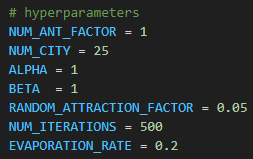
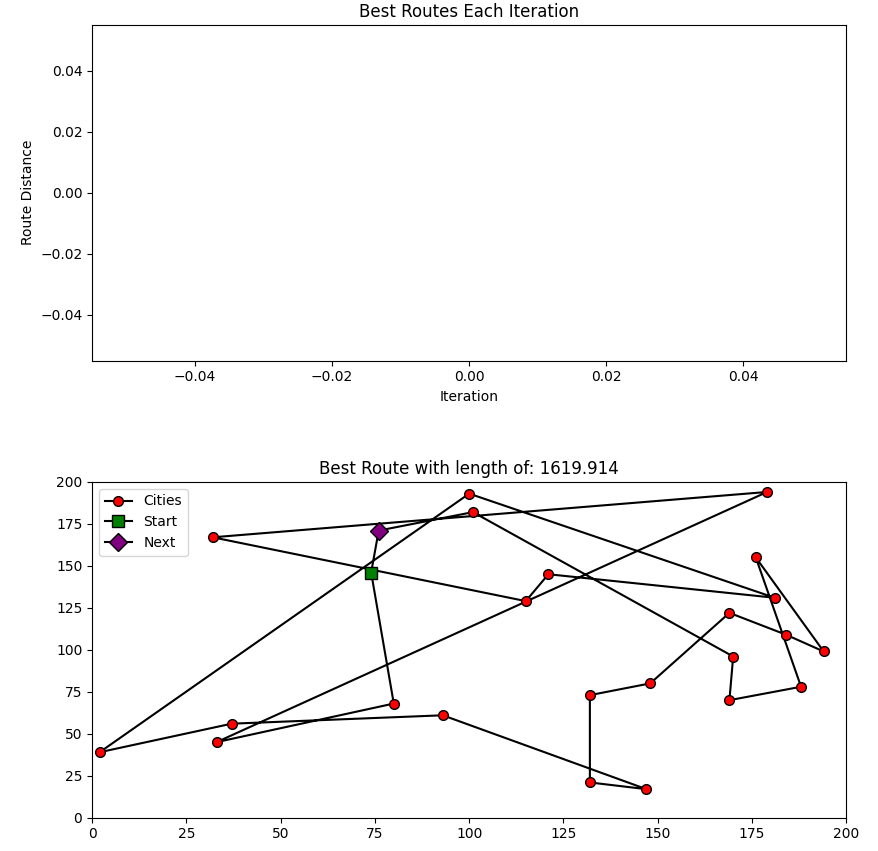
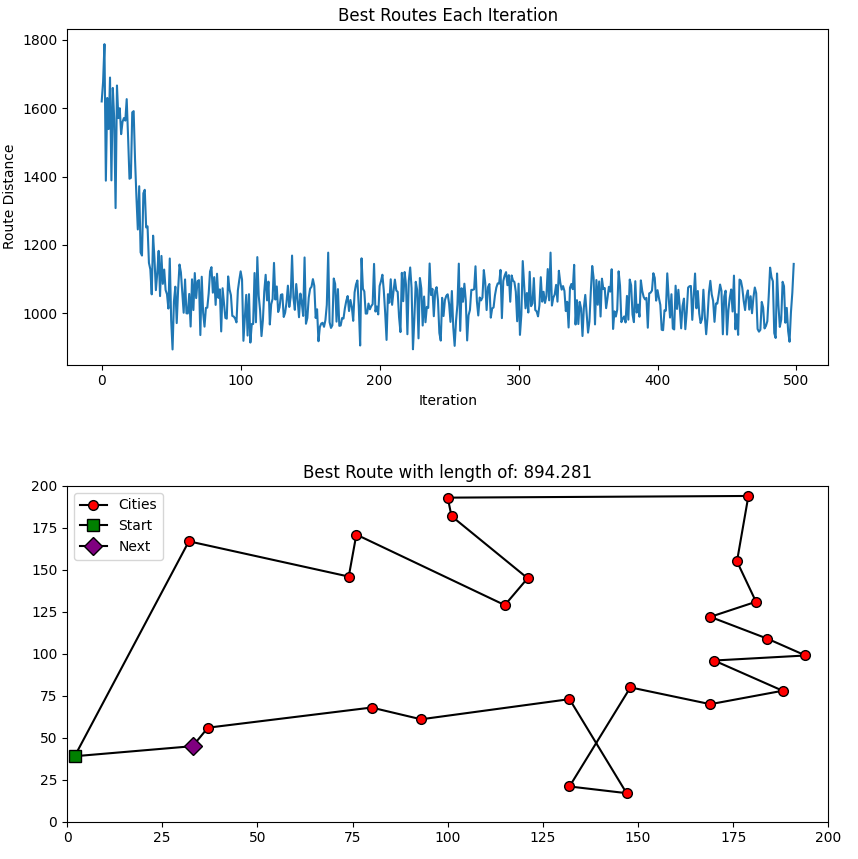


# Runtime 2 Plots
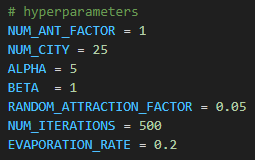
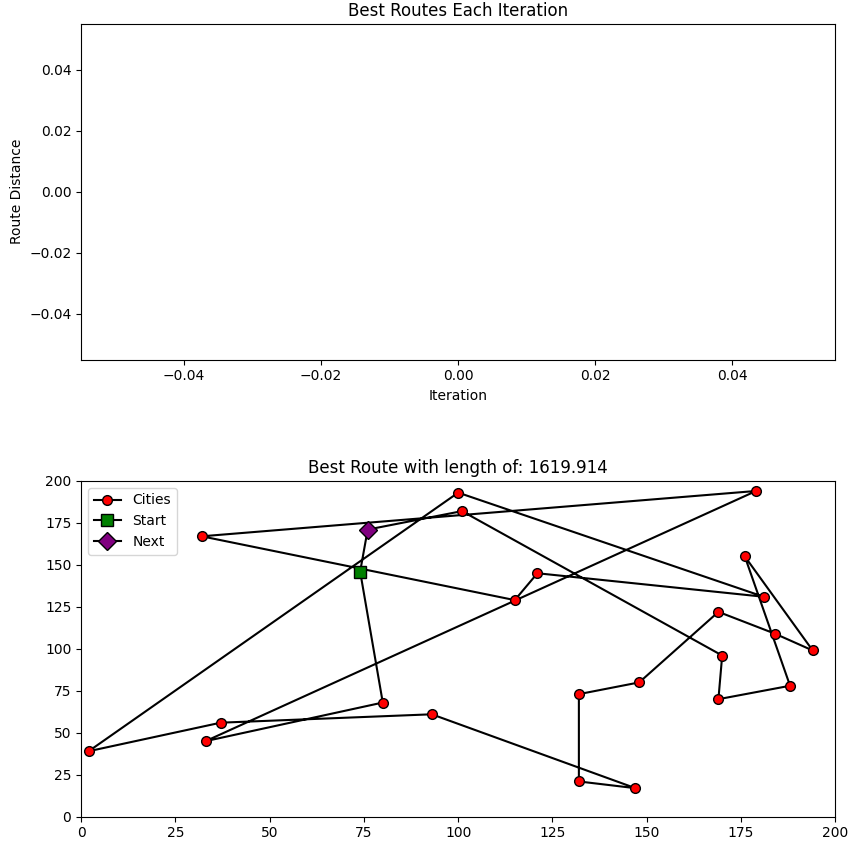
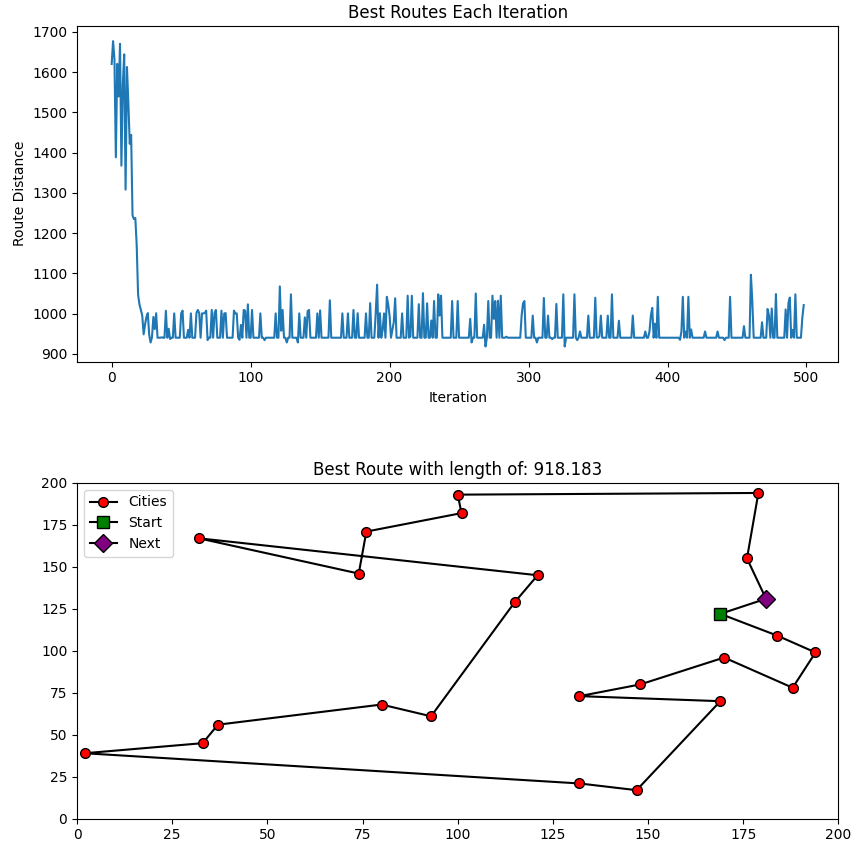

# Runtime 3 Plots
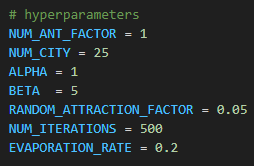
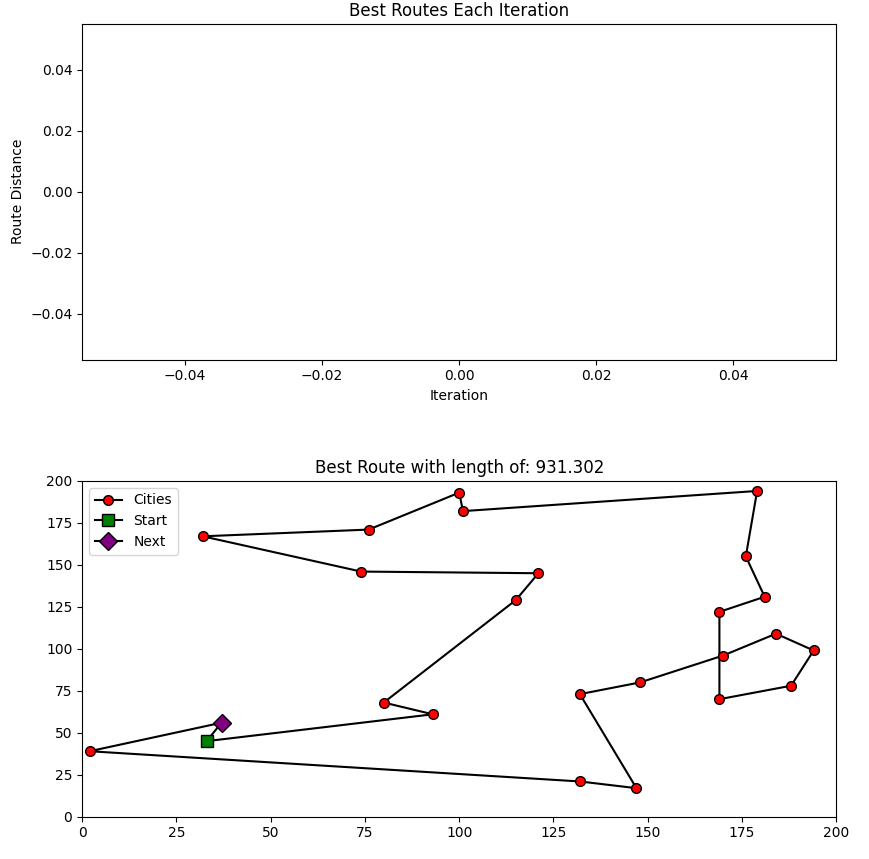
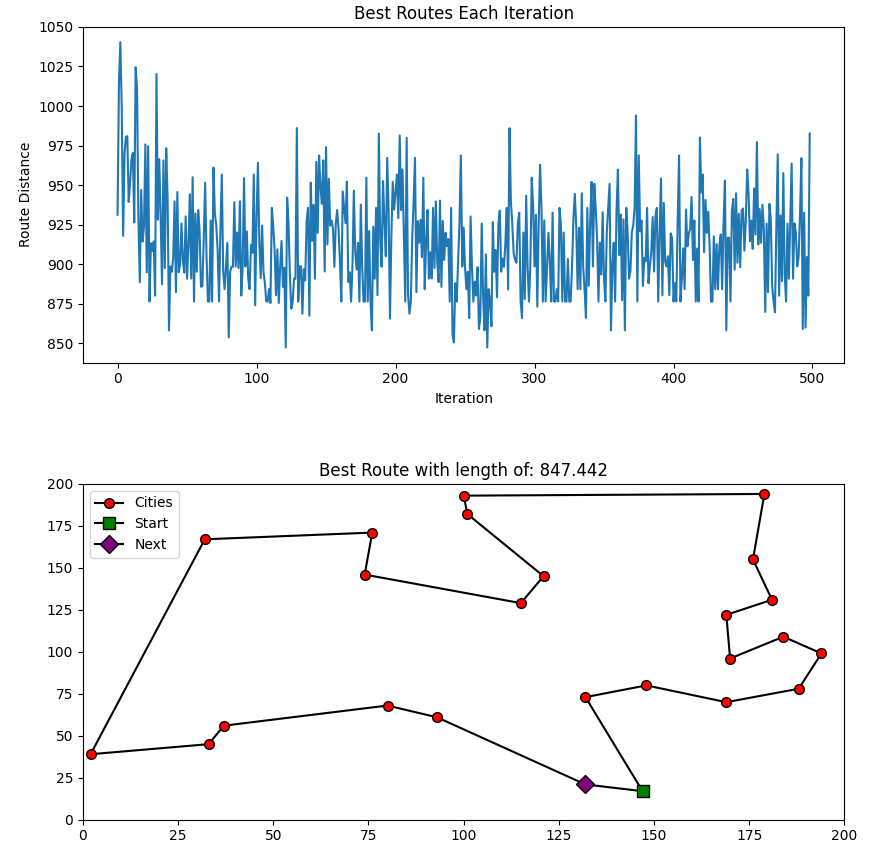